In [ ]:
# Unpacking best-performing text classiffier
# April 2025
# Violeta Berdejo-Espinola

In [ ]:
%pip install mpu scikit-learn matplotlib numpy embetter imblearn scipy shap sentence_transformers stop-words WordCloud

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# read data

In [10]:
import mpu

# raw corpus

x = mpu.io.read('../data/v2/corpus_raw.pickle')

# y

y = mpu.io.read('../data/v2/y.pickle')

# calculate weights

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y)
weights = compute_class_weight('balanced', classes=classes, y=y)
class_weight_dict = dict(zip(classes, weights))

In [32]:
classes, weights

(array([0, 1]), array([ 0.50399564, 63.06818182]))

# best models


In [ ]:
from imblearn.pipeline import make_pipeline 

from embetter.text import SentenceEncoder

from sklearn.svm import SVC

from sklearn.model_selection import cross_val_predict, StratifiedKFold

from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

import numpy as np

def train_eval_best_model(x_train, y_train, x_test, y_test, kfold, C):
    
    """"
    Train and test model
    
    Parameters:
    -----------
    x_train, x_test: list of strings
        raw text to create embeddings
    y_train_y_test: array 
        binary labels
    text_length: string 
        indicating whther it is 'text and asbtract' or 'text, asbtract, and main text'
    kfold: int
        indicating number of folds for cross validation
    embedding_model: string
        instantiation of embedding model
    random_state: int
        seed
    C: int
        strength of regularisation parametre

        
    Returns:
    --------
    Dictionary with scores.
    Aray of predictions and predicted probabilities.
    Log losss values for test and train set.
    Array of test set predicitons
    Model object
    AIC value
    """
    
    pipeline = make_pipeline(
        SentenceEncoder('paraphrase-multilingual-mpnet-base-v2'),
        SVC(kernel='linear', class_weight=class_weight_dict, probability=True, C=C)

    )
    
    #train model
    y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict') 

    pipeline.fit(x_train, y_train)
    
    # make predictions
    y_train_pred = pipeline.predict(x_train)

    y_test_pred = pipeline.predict(x_test)
    
    y_train_pred_proba = pipeline.predict_proba(x_train) 
    
    y_test_pred_proba = pipeline.predict_proba(x_test)  
    
    # log loss 
    logloss_tr = log_loss(y_train, y_train_pred_proba) 
    
    logloss_ts = log_loss(y_test, y_test_pred_proba)
    
    # model object -svm / logreg-
    model = pipeline.steps[-1][1]  

    # get model scores 
    scores = {
        'CV': kfold,
        'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
        'F1_tr': round(f1_score(y_train, y_train_pred), 3),
        'F1_ts': round(f1_score(y_test, y_test_pred), 3),
        'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
        'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
        'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
        'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
        'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
        'Recall_ts': round(recall_score(y_test, y_test_pred), 3)
        }
    
    print(f'loss training set: {logloss_tr}, \nloss test set {logloss_ts}')
    print(f'confusion matrix train set:\n{confusion_matrix(y_train, pipeline.predict(x_train))}')
    print(f'confusion matrix test set:\n{confusion_matrix(y_test, pipeline.predict(x_test))}') 
 
    return scores, y_train_pred, y_test_pred, y_train_pred_proba, y_test_pred_proba, logloss_tr, logloss_ts, model

# train-test model on different train-test partitions


run on a few different train-test partitions, then report the average with the standard error.
I should see greater performance with more data, but also lower variance across the different random samples

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)

scores1, y_train_pred1, y_test_pred1, y_train_pred_proba1, y_test_pred_proba1, logloss_tr1, logloss_ts1, model1= train_eval_best_model(x_train, y_train, x_test, y_test, 2, 0.01)

print(scores1)
print(np.mean(y_test_pred1 == y_test))

loss training set: 0.02930555548943624, 
loss test set 0.03708472104530252
confusion matrix train set:
[[3538  867]
 [   0   35]]
confusion matrix test set:
[[867 234]
 [  0   9]]
{'CV': 2, 'F1_tr_cv': 0.068, 'F1_tr': 0.075, 'F1_ts': 0.071, 'Precision_tr_cv': 0.035, 'Precision_tr': 0.039, 'Precision_ts': 0.037, 'Recall_tr_cv': 0.829, 'Recall_tr': 1.0, 'Recall_ts': 1.0}
0.7891891891891892


In [13]:
model1

SVC(C=0.01, class_weight={0: 0.5039956411187795, 1: 63.06818181818182},
    kernel='linear', probability=True)

In [33]:
y_test_pred1

array([1, 1, 0, ..., 0, 0, 0])

In [15]:
from scipy import stats

# stats.sem([logloss_ts1, logloss_ts2, logloss_ts3, logloss_ts])

# classification labels

In [114]:
import pandas as pd

dat = pd.DataFrame({"x_test":x_test,
                    "y_test":y_test,
                    "y_pred":y_test_pred1})

dat['prediction'] = np.select(
    [
        (dat['y_test'] == 0) & (dat['y_pred'] == 0),  # True Negative
        (dat['y_test'] == 1) & (dat['y_pred'] == 1),  # True Positive
        (dat['y_test'] == 0) & (dat['y_pred'] == 1),  # False Positive
        (dat['y_test'] == 1) & (dat['y_pred'] == 0)   # False Negative
    ],
    ["tn", "tp", "fp", "fn"],
    default="unknown"
)

# create dfs

tp = dat.loc[dat['prediction'] == "tp"]
tn = dat.loc[dat['prediction']== "tn"]
fp = dat.loc[dat['prediction']== "fp"]
fn = dat.loc[dat['prediction']== "fn"] # zero

# create lists with text only

tp_text = tp['x_test']
tn_text = tn['x_test']
fp_text = fp['x_test']

dat

,x_test,y_test,y_pred,prediction
0,Divergencias en la estimación de receptividad ...,0,1,fp
1,Efecto de la intemperización y proceso en las ...,0,1,fp
2,"Diversidad, composición y estructura de la veg...",0,0,tn
3,Análisis trófico de phymaturus punae (iguania:...,0,0,tn
4,Tamaño de fragmentos forestales en el bosque d...,0,0,tn
...,...,...,...,...
1105,Protozapotecia unamensis sp nov (annelida: cra...,0,0,tn
1106,Estimación de edades mediante análisis dentale...,0,0,tn
1107,Evaluación genotóxica del agua del río grande ...,0,0,tn
1108,Efecto letal agudo de los insecticidas en form...,0,0,tn


# explainability

In [26]:
import shap
from sentence_transformers import SentenceTransformer

classes = np.unique(y)

# encode text
encoder = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
X = encoder.encode(x)
print(f"Encoded data shape: {X.shape}")

Encoded data shape: (5550, 768)
SHAP Explainer with probability values initialized.
SHAP Explainer with log odd values initialized.


In [30]:
# define SHAP masker 
masker = shap.maskers.Text(tokenizer=r"\W+") # split on non-word characters

# define and prediction function
def prediction_function(text_batch): #ensure text_batch is a list of strings, SHAP might pass numpy arrays
    
    """Encodes perturbed text into embeddings and returns class probabilities."""
    
    if isinstance(text_batch, np.ndarray):
        text_batch = text_batch.tolist()
    try:
        embeddings = encoder.encode(text_batch) 
        probas = model1.predict_proba(embeddings)

        return probas#[:, 0]  # shape: (batch_size,)
   
    except Exception as e:
        print(f"Error during prediction function execution: {e}")
        # Return a default value or re-raise depending on desired handling
        # Returning zeros matching expected output shape might help SHAP proceed
        # return shape (batch_size, num_classes)
        return np.zeros((len(text_batch), len(classes)))

# initialize SHAP explainer for logreg
explainer = shap.Explainer(prediction_function, masker, output_names=["Class 0", "Class 1"]) 
print("SHAP Explainer with probability values initialized.")

# define score function
def score_function(text_batch):
    
    """Encodes perturbed text into embeddings and returns class probabilities."""
    
    if isinstance(text_batch, np.ndarray):
        text_batch = text_batch.tolist()
    try:
        embeddings = encoder.encode(text_batch) 
        # probas = model1.predict_proba(embeddings)

        # return probas#[:, 0]  # shape: (batch_size,)
        scores = model1.decision_function(embeddings)
        return scores
    except Exception as e:
        print(f"Error during prediction function execution: {e}")

        # return shape (batch_size, num_classes)
        return np.zeros((len(text_batch), len(classes)))

# initialize SHAP explainer for svm
score_explainer = shap.Explainer(score_function, masker)
print("SHAP Explainer with log odd values initialized.")

SHAP Explainer with probability values initialized.
SHAP Explainer with log odd values initialized.


# explain positive instances

In [17]:
# print(f"\nExplaining a positive instance.")
# shap_values_t = explainer(x_test[385:386]) #

# print("SHAP values calculated.")
# shap.plots.text(shap_values_t)

In [121]:
print(f"\nExplaining a positive instance.")
# shap_values_pos = score_explainer(tp_text[:]) #

# print("SHAP values calculated.")
# shap.plots.text(shap_values_pos)


Explaining a positive instance.


In [ ]:
# save shap.plot as html

with open('../results/v2/shap_plot_text_true_positive.html', 'w') as file:
     file.write(shap.plots.text(shap_values_pos, display=False))

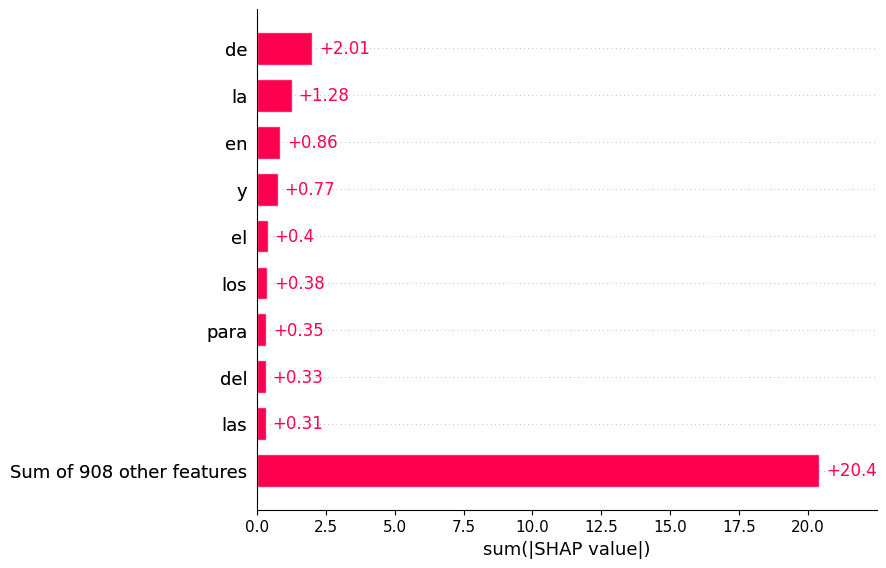

In [99]:
# features having the largest impact in positive predictions

import matplotlib.pyplot as plt

shap_plot = shap.plots.bar(shap_values_pos.abs.sum(0), show=False)

# plt.savefig("../results/v2/shap_plot_true_positives.png",dpi=700, format="png", bbox_inches="tight")

plt.show()

In [83]:
shap_values_pos

.values =
array([array([ 0.03942844,  0.03942844,  0.05150914,  0.05796986,  0.05061645,
               0.05061645,  0.08436416,  0.10436536,  0.02375669,  0.02375669,
               0.02441888,  0.02441888,  0.02840877,  0.02840877,  0.02840877,
               0.02840877,  0.01434644,  0.01434644,  0.01434644,  0.01434644,
               0.00396019,  0.00396019,  0.00098928,  0.00098928, -0.00077968,
              -0.00077968,  0.00040987,  0.00040987,  0.00032386,  0.00032386,
              -0.00225079, -0.00225079,  0.00495871,  0.00495871, -0.00383904,
              -0.00383904, -0.02224118, -0.02224118,  0.00011196, -0.00909048,
               0.01369844,  0.01369844,  0.01436247,  0.01436247,  0.03324048,
               0.03324048,  0.03301288,  0.03301288,  0.03879733,  0.03879733,
               0.01381805,  0.01381805,  0.00848886,  0.00848886,  0.00848886,
               0.00848886, -0.00098269, -0.00098269, -0.00098269, -0.00098269,
              -0.0026024 , -0.0026024 , -0

# explain negative instances

In [101]:
print(f"\nExplaining a negative instance")

shap_values_neg = score_explainer(tn_text[:])

print("SHAP values calculated.")


Explaining a negative instance


PartitionExplainer explainer: 868it [2:11:38,  9.13s/it]                             


SHAP values calculated.


In [120]:
# shap.plots.text(shap_values_neg)

In [ ]:
# save shap.plot as html

import matplotlib.pyplot as plt

with open('../results/v2/shap_plot_text_true_negatives.html', 'w') as file:
     file.write(shap.plots.text(shap_values_neg, display=False))

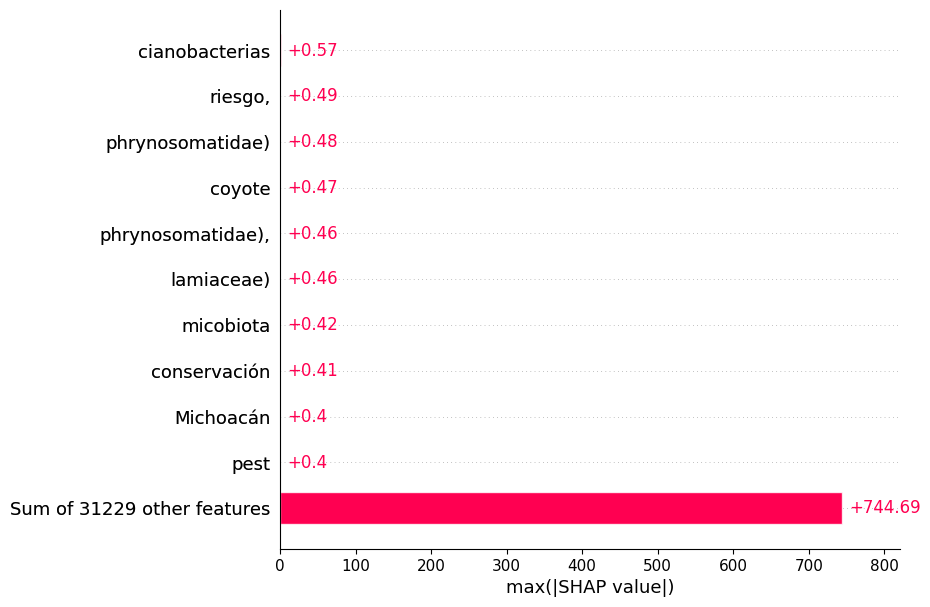

In [108]:
# features having the largest impact in positive predictions

shap_plot = shap.plots.bar(shap_values_neg.abs.max(0), show=False, max_display=11)

# plt.savefig("../results/v2/shap_plot_true_negatives_min.png",dpi=700, format="png", bbox_inches="tight")

plt.show()

# explain false positves

In [116]:
print(f"\nExplaining a false positive instances")

shap_values_false_pos = score_explainer(fp_text[:])

print("SHAP values calculated.")


Explaining a false positive instances


PartitionExplainer explainer: 235it [18:36,  4.79s/it]                         

SHAP values calculated.


In [ ]:
# shap.plots.text(shap_values_false_pos)

In [118]:
# save shap.plot as html

import matplotlib.pyplot as plt
from IPython.core.display import HTML

with open('../results/v2/shap_plot_text_false_positives.html', 'w') as file:
     file.write(shap.plots.text(shap_values_false_pos, display=False))

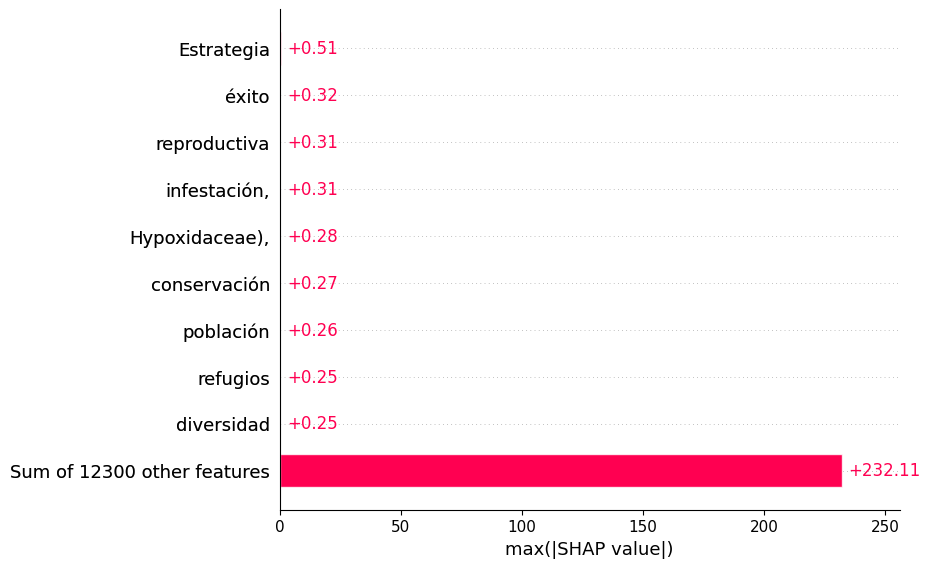

In [122]:
# features having the largest impact in positive predictions

shap_plot = shap.plots.bar(shap_values_false_pos.abs.max(0), show=False)

plt.savefig("../results/v2/shap_plot_false_positives.png",dpi=700, format="png", bbox_inches="tight")

plt.show()

# error analysis

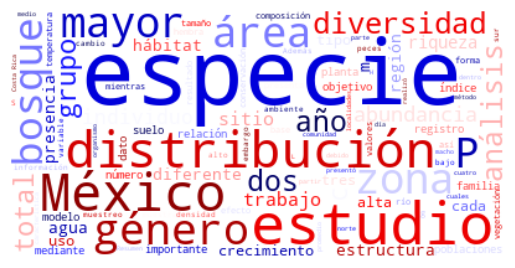

(<wordcloud.wordcloud.WordCloud at 0x6453cc650>,
 shape: (1, 1_000)
 ┌─────────┬─────────┬──────────┬──────────────┬───┬──────────┬──────────┬──────────┬────────────┐
 │ especie ┆ estudio ┆ México   ┆ distribución ┆ … ┆ destaca  ┆ adecuado ┆ error    ┆ Asteraceae │
 │ ---     ┆ ---     ┆ ---      ┆ ---          ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---        │
 │ f64     ┆ f64     ┆ f64      ┆ f64          ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64        │
 ╞═════════╪═════════╪══════════╪══════════════╪═══╪══════════╪══════════╪══════════╪════════════╡
 │ 1.0     ┆ 0.28269 ┆ 0.223537 ┆ 0.212951     ┆ … ┆ 0.009963 ┆ 0.009963 ┆ 0.009963 ┆ 0.009963   │
 └─────────┴─────────┴──────────┴──────────────┴───┴──────────┴──────────┴──────────┴────────────┘)

In [164]:
from wordcloud import WordCloud

from stop_words import get_stop_words

import matplotlib.pyplot as plt
%matplotlib inline

# true positive

def create_wordcloud(text, name):
    stop_words = get_stop_words('spanish')
    
    wordcloud = WordCloud(background_color="white", colormap='seismic_r', max_words=1000, stopwords=stop_words).generate(' '.join(text))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    word_freq = wordcloud.words_
    word_freq = pl.DataFrame(word_freq)
    # wordcloud.to_file(f'../results/v2/wordcloud_{name}.png')
    word_freq.write_csv('../results/v2/word_relative_frequency_tn.csv')
    
    return wordcloud, word_freq
    
create_wordcloud(tn_text, 'tn')

# performance plots


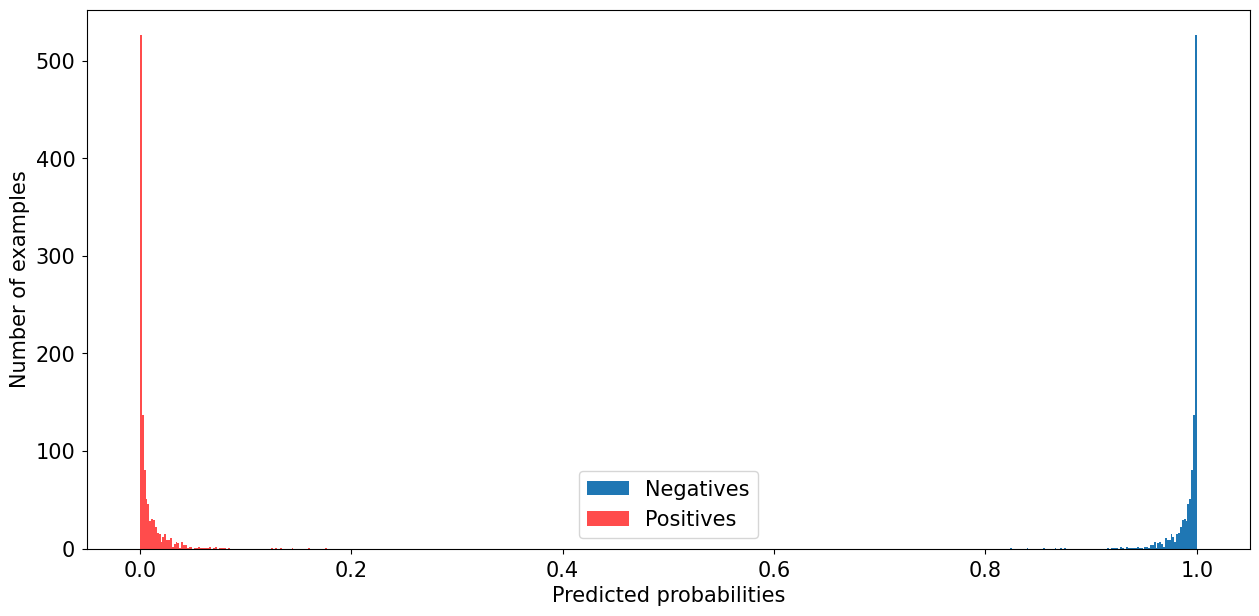

In [23]:
import matplotlib.pyplot as plt

y_pred_ts_p = y_test_pred_proba1[:,1] # subset class of interest --> 1d array
y_pred_ts_n = y_test_pred_proba1[:,0]

plt.figure(figsize=(15,7))
plt.hist(y_pred_ts_n, bins=100, label='Negatives')
plt.hist(y_pred_ts_p, bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Predicted probabilities', fontsize=15)
plt.ylabel('Number of examples', fontsize=15)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=15, pad=5)
# plt.savefig('../results/model_scores/predicted_proba_logreg_ts.png', dpi=800)
plt.show() 


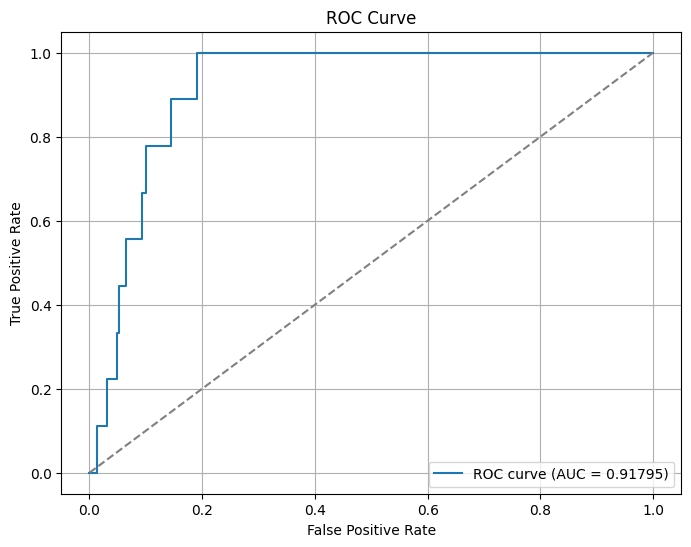

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# True labels and predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_ts_p)
auc_score = roc_auc_score(y_test, y_pred_ts_p)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.5f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
# plt.savefig('../results/v2/roc_curve.png', dpi=1000)
plt.show()

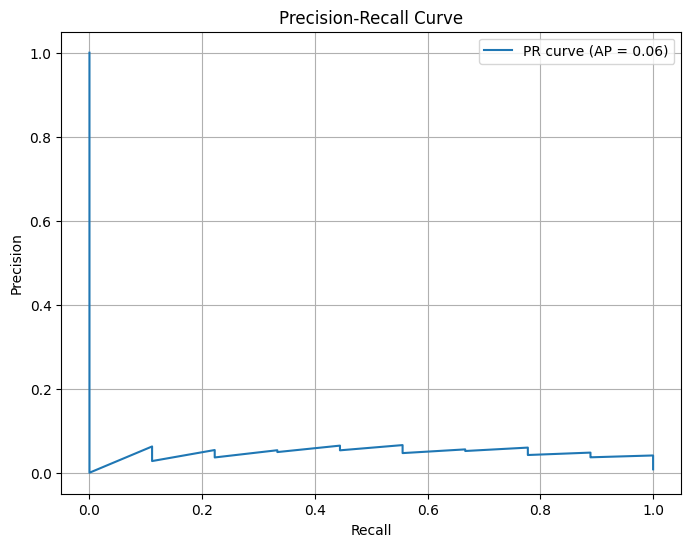

In [25]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_true = y_test

precision, recall, thresholds = precision_recall_curve(y_true, y_pred_ts_p)
ap_score = average_precision_score(y_true, y_pred_ts_p)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()